In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import random
import plotly.express as px
import numpy as np

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook the Percent Replicating score for DMSO at each position is computed for the following U2OS 48h time point compound plates
1. Whole plate normalized CP profiles
2. Spherized CP profiles
3. Spherized DL profiles

The following are the steps taken
1. Whole plate normalized CP profiles, Spherized CP profiles and Spherized DL profiles from the 48h Compound experiment are read and the replicates plates merged into a single dataframe.
2. All the non-negative control wells are removed.
3. DMSO wells in the same position are considered replicates while DMSO wells in different positions are considered non-replicates.
4. The signal distribution, which is the median pairwise replicate correlation, is computed for each replicate.
5. The null distribution, which is the median pairwise correlation of non-replicates, is computed for 1000 combinations of non-replicates.
6. Percent Replicating is computed as the percentage of the signal distribution that is the greater than the 95th percentile of null distribution
7. The signal and noise distributions and the Percent Replicating values are plotted and the table of Percent Replicating is printed.

In [2]:
n_samples = 1000
n_replicates = 4

corr_replicating_df = pd.DataFrame()
group_by_feature = 'Metadata_Well'
perturbation = "compound"
cell = "U2OS"
time = "48"

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch=="2020_11_04_CPJUMP1" or Batch=="2020_11_04_CPJUMP1_DL"')
    .query('Perturbation==@perturbation')
    .query('Cell_type==@cell')
    .query('Time==@time')
)

batches = {
    "2020_11_04_CPJUMP1": {
        "normalized": "normalized.csv.gz",
        "spherized": "spherized.csv.gz"
    },
    "2020_11_04_CPJUMP1_DL": {
        "spherized": "spherized.csv.gz"
    }
}

In [3]:
for batch in experiment_df.Batch.unique():
    for type in batches[batch]:
        filename = batches[batch][type]
        batch_df = experiment_df.query('Batch==@batch')
        data_df = pd.DataFrame()
        for plate in experiment_df.Assay_Plate_Barcode.unique():
            plate_df = utils.load_data(batch, plate, filename)
            data_df = utils.concat_profiles(data_df, plate_df)

        data_df = data_df.query('Metadata_control_type=="negcon"')

        metadata_df = utils.get_metadata(data_df)
        features_df = utils.get_featuredata(data_df).replace(np.inf, np.nan).dropna(axis=1, how="any")
        data_df = pd.concat([metadata_df, features_df], axis=1)

        replicating_corr = list(utils.corr_between_replicates(data_df, group_by_feature)) # signal distribution
        null_replicating = list(utils.corr_between_non_replicates(data_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name = group_by_feature)) # null distribution

        prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating,
                                                                        replicating_corr,
                                                                        how='right')

        if batch == "2020_11_04_CPJUMP1":
            features = 'CellProfiler'
        else:
            features = 'DeepProfiler'

        corr_replicating_df = corr_replicating_df.append({'Description':f'{features}_{type}',
                                                          'Modality':f'{perturbation}',
                                                          'Cell':f'{cell}',
                                                          'time':f'{time}',
                                                          'Replicating':replicating_corr,
                                                          'Null_Replicating':null_replicating,
                                                          'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                          'Value_95':value_95_replicating}, ignore_index=True)

In [4]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description             |   Percent_Replicating |
|:------------------------|----------------------:|
| CellProfiler_normalized |                  40.6 |
| CellProfiler_spherized  |                  26.6 |
| DeepProfiler_spherized  |                  32.8 |


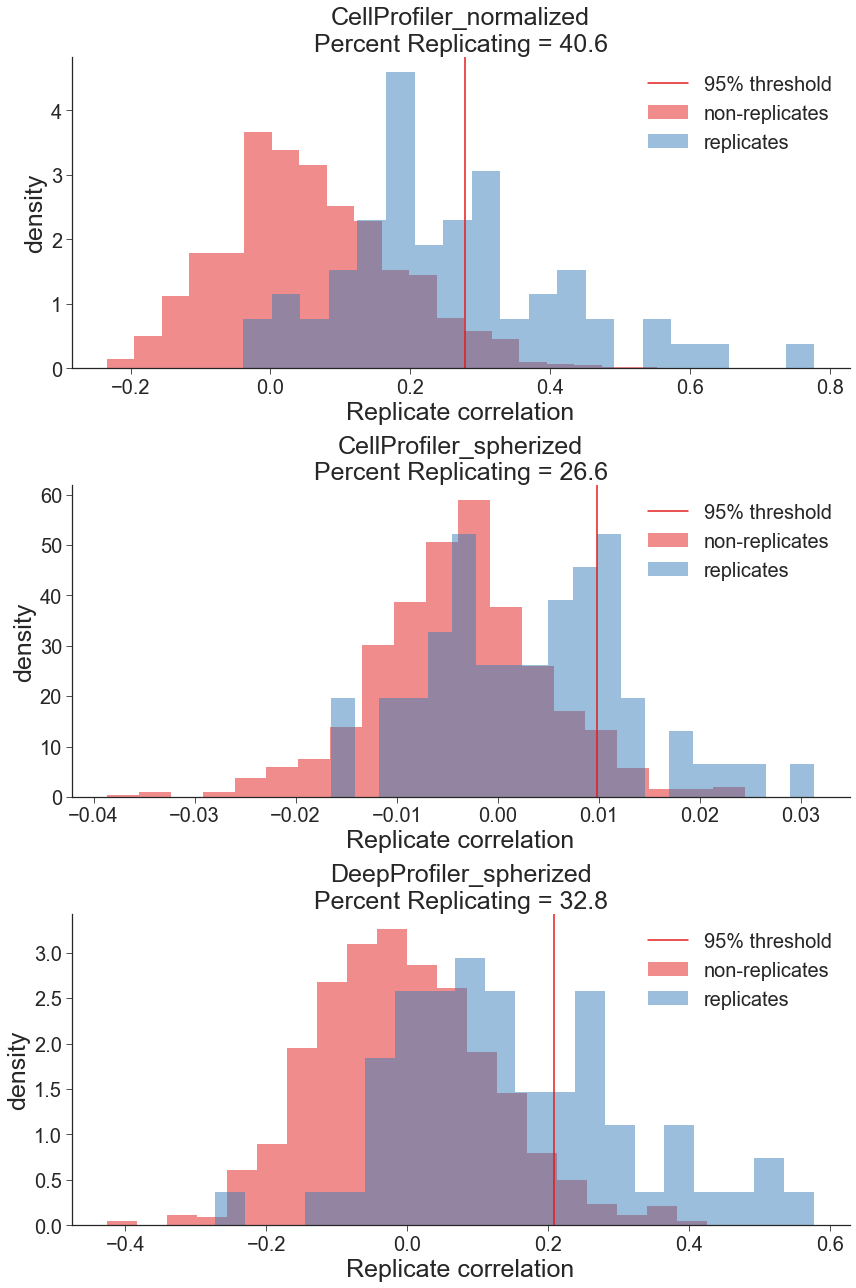

In [5]:
utils.distribution_plot(df=corr_replicating_df, output_file="5.percent_replicating.png", metric="Percent Replicating")

In [6]:
corr_replicating_df['Percent_Replicating'] = corr_replicating_df['Percent_Replicating'].astype(float)

corr_replicating_df.loc[(corr_replicating_df.Modality=='compound') & (corr_replicating_df.time=='48'), 'time'] = 'long'

plot_corr_replicating_df = (
    corr_replicating_df.rename(columns={'Modality':'Perturbation'})
    .drop(columns=['Null_Replicating','Value_95','Replicating'])
)

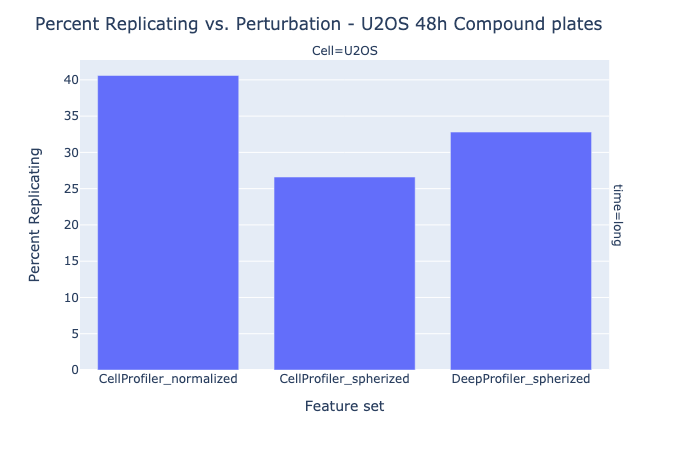

In [7]:
fig = px.bar(data_frame=plot_corr_replicating_df,
             x='Description',
             y='Percent_Replicating',
             facet_row='time',
             facet_col='Cell')
fig.update_layout(title='Percent Replicating vs. Perturbation - U2OS 48h Compound plates',
                  xaxis=dict(title='Feature set'),
                  yaxis=dict(title='Percent Replicating'),
                  yaxis3=dict(title='Percent Replicating'))
fig.show("png")
fig.write_image(f'figures/5.percent_replicating_facet.png', width=640, height=480, scale=2)

In [8]:
print(plot_corr_replicating_df[['Description','Perturbation','time', 'Cell' ,'Percent_Replicating']].to_markdown(index=False))


| Description             | Perturbation   | time   | Cell   |   Percent_Replicating |
|:------------------------|:---------------|:-------|:-------|----------------------:|
| CellProfiler_normalized | compound       | long   | U2OS   |                  40.6 |
| CellProfiler_spherized  | compound       | long   | U2OS   |                  26.6 |
| DeepProfiler_spherized  | compound       | long   | U2OS   |                  32.8 |
